In [29]:
file = 'dating_data.csv'

In [85]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency
from statsmodels.regression.linear_model import OLS

import pingouin as pg

In [31]:
df = pd.read_csv(file)

In [32]:
df.head(10)

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1
5,227,162,0,0
6,435,16,1,0
7,602,327,1,0
8,223,295,0,0
9,133,463,1,1


# Дескрипшн:

Механика приложения следующая: 
- пользователи видят в приложении анкеты друг друга и могут ставить друг другу лайки или дизлайки. <strong>user_id_1 & user_id_2</strong>
- Если пользователи поставили друг другу лайк – это называется мэтч <strong>is_match</strong>

<strong>Команда приложения разработала новый алгоритм для поиска наиболее подходящих анкет. Для проверки работы алгоритма был проведен АБ-тест. </strong>

Все пользователи были разделены на две группы:
- Пользователи в группе с номером 0 пользовались приложением со старым алгоритмом КОНТРОЛЬНАЯ ГРУППА. <strong>group == 0</strong>
- Все пользователи в группе 1 пользовались приложением с новым алгоритмом для поиска анкет ТЕСТОВАЯ ГРУППА. <strong>group == 1</strong>

Для каждой пары пользователей указано, из какой они группы АБ-теста и случился ли у них мэтч.

<strong>Ваша задача</strong> – оценить, правда ли, что новый алгоритм улучшил качество сервиса. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах. Результат вашей работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему поиска анкет на всех пользователей.



In [33]:
# все инты
df.dtypes

user_id_1    int64
user_id_2    int64
group        int64
is_match     int64
dtype: object

In [34]:
# пропущенки?
df.isna().sum()

user_id_1    0
user_id_2    0
group        0
is_match     0
dtype: int64

In [35]:
# сколько выборка?
df.shape

(14514, 4)

In [36]:
# какие выборки по группам алгоритмов? не равные но достаточно большие
df.groupby('group').count()

,user_id_1,user_id_2,is_match
group,,,
0,4792,4792,4792
1,9722,9722,9722


In [76]:
# кол-во уникальных пользователей в user_id_1
df.groupby('group').agg({'user_id_1' : 'nunique'})

,user_id_1
group,
0,501
1,499


In [77]:
# кол-во уникальных пользователей в user_id_2
df.groupby('group').agg({'user_id_2' : 'nunique'})

,user_id_2
group,
0,501
1,499


одиноково в user_id_1 и user_id_2, наверное и не удивительно - ведь в дф по сути айдишники пар и их мэтч/немэтч

In [78]:
# посмотрим сколько у нас вообще мэтчей и НЕ мэтчей в двух группах
df.groupby(['group', 'is_match']).count()

user_id_1  user_id_2
group is_match                      
0     0              3858       3858
      1               934        934
1     0              5813       5813
      1              3909       3909

Мэтчей в тестовой группе 1 стало относительно больше

In [71]:
"""========================================================================================================================"""

'========================================================================================================================'

1. Выбрать подходящую метрику:\
    1.1. Кол-во мэтчей \
    1.2. Доля мэтчей в группах относительно общего их числа
    

<h2>А статистически значимо ли то, что мэтчей в тестовой группе стало больше? Попробуем через Хи квадрат</h2>

In [39]:
# Создаем таблицу сопряженности
contingency_table = pd.crosstab(df['group'], df['is_match'])

In [40]:
contingency_table

is_match,0,1
group,,
0,3858,934
1,5813,3909


In [80]:
# Применяем Хи-квадрат тест
chi2, p, _, _ = chi2_contingency(contingency_table)

# Выводим результаты
print("Хи-квадрат статистика:", chi2)
print("p-value:", p)
if p < 0.05:
    print('Отклоняем Н_0')
else:
    print('Не отколняем Н_0')

Хи-квадрат статистика: 618.6889141576198
p-value: 1.4418299163662586e-136
Отклоняем Н_0


In [87]:
expected, observed, stats = pg.chi2_independence(df, x = 'group', y = 'is_match')

In [89]:
expected

is_match,0,1
group,,
0,3193.015847,1598.984153
1,6477.984153,3244.015847


In [90]:
observed

is_match,0,1
group,,
0,3857.5,934.5
1,5813.5,3908.5


In [91]:
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,618.688914,1.0,1.441830e-136,0.206463,1.0
1,cressie-read,0.666667,628.560791,1.0,1.027630e-138,0.208104,1.0
2,log-likelihood,0.000000,652.966812,1.0,5.056969e-144,0.212106,1.0
3,freeman-tukey,-0.500000,675.931262,1.0,5.125545e-149,0.215803,1.0
4,mod-log-likelihood,-1.000000,703.556093,1.0,5.039774e-155,0.220169,1.0
5,neyman,-2.000000,775.869247,1.0,9.519662e-171,0.231207,1.0


<h2>Стало ли больше мэтчей?</h2>

In [106]:
# группа с мэтчами из контрольной группы
match_gr0 = df.query(" is_match == 1 and group == 0").groupby(['group', 'user_id_1'], as_index=False).size()
match_gr0

,group,user_id_1,size
0,0,4,2
1,0,10,3
2,0,12,1
3,0,15,3
4,0,17,1
...,...,...,...
417,0,994,2
418,0,995,2
419,0,996,1
420,0,997,1


In [130]:
# группа с мэтчами из тестовой группы
match_gr1 = df.query(" is_match == 1 and group == 1").groupby(['group', 'user_id_1'], as_index=False).size()
match_gr1

,group,user_id_1,size
0,1,1,11
1,1,2,7
2,1,3,5
3,1,5,13
4,1,6,9
...,...,...,...
493,1,987,8
494,1,992,8
495,1,993,6
496,1,998,10


In [134]:
# Настройки стиля seaborn
sns.set_style("whitegrid")
# Создание графиков
plt.figure(figsize=(10, 6))  # Установка размера графика

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

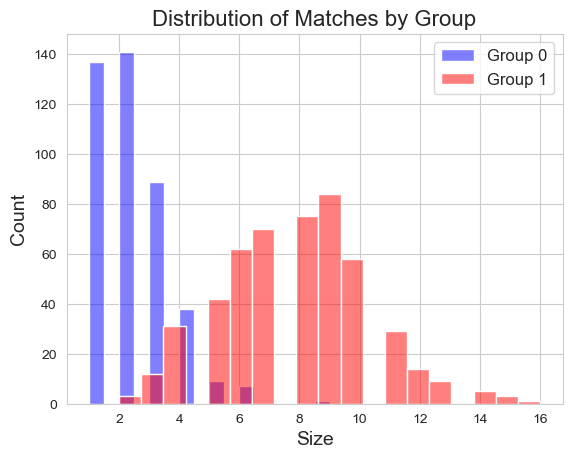

In [136]:
sns.histplot(match_gr0['size'], color='blue', alpha=0.5, label='Group 0')  # Гистограмма для группы 0
sns.histplot(match_gr1['size'], color='red', alpha=0.5, label='Group 1')  # Гистограмма для группы 1

# Настройка заголовка и меток осей
plt.title('Distribution of Matches by Group', fontsize=16)
plt.xlabel('Size', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Добавление легенды
plt.legend(fontsize=12)

# Отображение графика
plt.show()

Занятно, что распределение мэтчей разное для двух групп:\
- если в контрольной распределение убывающее (т.е. большинство получало очень мало мэтчей)
- то в тестовой оно похоже на нормальное, и видно что максимальное число мэтчей на юзера увеличилось с примерно 8 до примерно 16

In [148]:
print(match_gr0['size'].max())
print(match_gr1['size'].max())
# Так нагляднее по максимам

9
16


In [164]:
print(match_gr0['size'].mean())
print(match_gr1['size'].mean())
# Так нагляднее по максимам

2.213270142180095
7.849397590361446


In [173]:
#
print(f" 95% процентиль интервал {match_gr0['size'].quantile(0.05)} and {match_gr0['size'].quantile(0.95)} для контрольной группы")

print(f" 95% процентиль интервал {match_gr1['size'].quantile(0.05)} and {match_gr1['size'].quantile(0.95)} для тестовой группы")

 95% процентиль интервал 1.0 and 4.0 для контрольной группы
 95% процентиль интервал 4.0 and 12.0 для тестовой группы


<h2>Стало ли больше пар предлагать (без учета мэтча)?</h2>

In [139]:
pair_gr_0 = df.query(" group == 0").groupby(['group', 'user_id_1'], as_index=False).size()
pair_gr_0

,group,user_id_1,size
0,0,4,9
1,0,10,6
2,0,12,12
3,0,14,8
4,0,15,20
...,...,...,...
496,0,994,9
497,0,995,8
498,0,996,8
499,0,997,12


In [138]:
pair_gr_1 = df.query(" group == 1").groupby(['group', 'user_id_1'], as_index=False).size()
pair_gr_1

,group,user_id_1,size
0,1,1,24
1,1,2,16
2,1,3,16
3,1,5,22
4,1,6,22
...,...,...,...
494,1,987,23
495,1,992,21
496,1,993,18
497,1,998,18


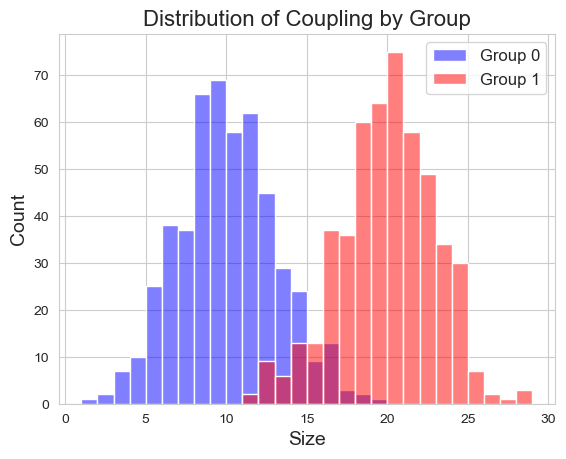

In [141]:
sns.histplot(pair_gr_0['size'], color='blue', alpha=0.5, label='Group 0')  # Гистограмма для группы 0
sns.histplot(pair_gr_1['size'], color='red', alpha=0.5, label='Group 1')  # Гистограмма для группы 1

# Настройка заголовка и меток осей
plt.title('Distribution of Coupling by Group', fontsize=16)
plt.xlabel('Size', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Добавление легенды
plt.legend(fontsize=12)

# Отображение графика
plt.show()

В целом я бы еще и сказал что пар предлагать стало больше к тестовой группе (Group 1), относительно контрольной
И раз распределение хотя бы похожи на нормальные можно попробовать т-тест стьюдента

In [159]:
# Проверка нормальности распределения

from scipy import stats

_, p_value_norm_gr0 = stats.normaltest(pair_gr_0['size'])
if p_value_norm_gr0 > 0.05: print('Распределение НЕ норм')
else: ''

Распределение НЕ норм


In [160]:
_, p_value_norm_gr1 = stats.normaltest(pair_gr_1['size'])
if p_value_norm_gr1 > 0.05: print('Распределение НЕ норм')
else: ''

Распределение НЕ норм


Требования для т-теста не выполнены, оба распределения не нормальные.

In [161]:
# Попробуем Манна_витни
from scipy.stats import mannwhitneyu


In [163]:
# Применяем U-тест Манна-Уитни
statistic, p_value = mannwhitneyu(pair_gr_0['size'], pair_gr_1['size'])

# Выводим результаты
print("Статистика U:", statistic)
print("p-value:", p_value)
if p_value > 0.05:
    print('Различия между выборками Стат. НЕ значимы !')
else:
    print('Различия между выборками Стат. значимы !')

Статистика U: 3316.0
p-value: 6.905154965510583e-157
Различия между выборками Стат. значимы !


# Итог
В тестовой группе мы видими:\
    1 - Приложение стало показывать больше пар пользователю, на графике распределение показов сдвинулось вправо\
    2 - Распрдееление Мэтчей изменилось, стало похоже на нормальное. То есть в среднем все стали получать среднее число мэтчей, в отличии от контрольной группы. Также увеличилось и макс. число мэтчей\
    3 - Статистически значимо изменение числа мэтчей в тестовой группе относительно контрольной.